In [1]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [196]:
# Import the necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pickle
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from itertools import chain

In [123]:
# Reading the dataset
path = '/content/drive/MyDrive/ai:ml-tasks/'
df_review = pd.read_csv(os.path.join(path,'Musical_instruments_reviews.csv'))
df_all = pd.read_csv(os.path.join(path, 'alldata.csv'))

# **Task-1**
* You have to categorise opinions expressed in feedback forums

In [124]:
# review the head of dataset
df_review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [125]:
# checking the scale of overall rating
print('Maximum rating scale of overall rating {}'.format(df_review.overall.max()))
print('Minimum rating scale of overall rating {}'.format(df_review.overall.min()))

Maximum rating scale of overall rating 5.0
Minimum rating scale of overall rating 1.0


* **NOTE:We should the categorize the opnion of the feedback based on the overall rating because overall rating indicate that how much customers are satisfied from that product. <br>**

* Rating and there General Meaning are follows <br>
<pre>
    Rating            General Meaning
    1.0               I hate it.
    2.0               I don't like it.
    3.0               It's okey.
    4.0               I like it.
    5.0               I love it.
</pre>



In [126]:
# defing the function for adding the category for the feedback
def add_category(df):

  if df['overall']==1.0:
    return "I hate it"
  elif df['overall']==2.0:
    return "I don't like it"
  elif df['overall'] == 3.0:
    return "It's okey"
  elif df['overall'] == 4.0:
    return "I like it"
  elif df['overall'] == 5.0:
    return "I love it"
  else:
    return -1


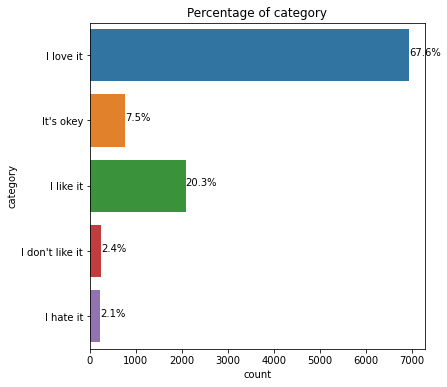

In [127]:
# adding the category in dataframe
df_review['category'] = df_review.apply(add_category, axis=1)
plt.figure(figsize=(6,6))
plt.title('Percentage of category')
ax = sns.countplot(y = 'category', data = df_review)
total = len(df_review)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


+ **We can see the above graph**<br>
<pre>
  67.6% customers love the product.
  7.5% customers it's okey.
  20.3% customers like the product.
  2.4% customres don't like the product.
  2.1% customers hate the product.
</pre>

# Task-2
+ You have to classify individual comments/reviews and you have to determine overall rating based on individual comments/reviews.

In [8]:
df_review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",I love it
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",I love it
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",I love it
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",I love it
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",I love it


In [9]:
# checking the total number of nan values of each features
df_review.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
category           0
dtype: int64

+ We can see the above only to two features has nan values reviewerName and reviewText respectively.
+ we can reviewText row whose values is nan because this is an important features. Curruently imput with missing string.

In [130]:
# imputing the reviewText features with missing 
df_review['reviewText'] = df_review.reviewText.fillna('missing')

# concating the reviewText and summary features
df_review['review']= df_review['reviewText'] +" "+ df_review['summary']

# deleting the summary column
df_review.drop(['summary','reviewText'], inplace=True, axis=1)


In [131]:
df_review.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,category,review
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",I love it,"Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",I love it,The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",I love it,The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",I love it,Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",I love it,This pop filter is great. It looks and perform...


* Our goal is predict the overall rating based on the comment/ review
* so review/comment is input feature and overall rating is the label
* This problem is mutliclass classification problem

In [132]:
# create a dataframe that has only reviewText and overall rating
df = df_review[['review', 'overall']].copy()
df.head()

,review,overall
0,"Not much to write about here, but it does exac...",5.0
1,The product does exactly as it should and is q...,5.0
2,The primary job of this device is to block the...,5.0
3,Nice windscreen protects my MXL mic and preven...,5.0
4,This pop filter is great. It looks and perform...,5.0


#### Text Preprocessing

In [134]:
# defing the funtion for remoing the punctuation
def clean(text):

  # converting the all the text into lowercase
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [135]:
# apply the clean function on dataframe
df['review'] = df.review.apply(lambda x: clean(x))
df.head()

,review,overall
0,not much to write about here but it does exact...,5.0
1,the product does exactly as it should and is q...,5.0
2,the primary job of this device is to block the...,5.0
3,nice windscreen protects my mxl mic and preven...,5.0
4,this pop filter is great it looks and performs...,5.0


In [136]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [137]:
# remove the stop_words from the reivew
df['review']= df.review.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))
df.head()

,review,overall
0,much write exactly supposed filters pop sounds...,5.0
1,product exactly quite affordablei realized dou...,5.0
2,primary job device block breath would otherwis...,5.0
3,nice windscreen protects mxl mic prevents pops...,5.0
4,pop filter great looks performs like studio fi...,5.0


In [138]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [139]:
# conveting the words into the root words using the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['review'] = df.review.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df.head()

,review,overall
0,much write exactly supposed filter pop sound r...,5.0
1,product exactly quite affordablei realized dou...,5.0
2,primary job device block breath would otherwis...,5.0
3,nice windscreen protects mxl mic prevents pop ...,5.0
4,pop filter great look performs like studio fil...,5.0


In [140]:
# converting the words into base words using stemming method
ps = PorterStemmer()
df['review']= df.review.apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
df.head()

,review,overall
0,much write exactli suppos filter pop sound rec...,5.0
1,product exactli quit affordablei realiz doubl ...,5.0
2,primari job devic block breath would otherwis ...,5.0
3,nice windscreen protect mxl mic prevent pop th...,5.0
4,pop filter great look perform like studio filt...,5.0


In [20]:
# featuers extraction most 5000 best features from the all featues with 1 to 3 gram using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
x = tfidf.fit_transform(df['review'])

In [21]:
# label of featuere
y = df['overall']
print('Origonal no samples of each ratting {}'.format(Counter(y)))
print('original shape of the input features {}'.format(x.shape))
print('origonal shape of the output features {}'.format(y.shape))

Origonal no samples of each ratting Counter({5.0: 6938, 4.0: 2084, 3.0: 772, 2.0: 250, 1.0: 217})
original shape of the input features (10261, 5000)
origonal shape of the output features (10261,)


+ we can easly see that five classess has different number of samples so we need to handle this
+ we are using the over_sampling technique to handle the imbalance dataset

In [22]:
# create the SMOTE over_sampling technique object and fit_resample the features
sm = SMOTE()
x_res, y_res = sm.fit_resample(x, y)
print('Before sampling the  shape of dataset {}'.format(Counter(y)))
print('After sampling the shape of dataset {}'.format(Counter(y_res)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before sampling the  shape of dataset Counter({5.0: 6938, 4.0: 2084, 3.0: 772, 2.0: 250, 1.0: 217})
After sampling the shape of dataset Counter({5.0: 6938, 3.0: 6938, 4.0: 6938, 2.0: 6938, 1.0: 6938})


In [23]:
# create the test and train set
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, random_state=0, test_size=0.25)

In [26]:
# model selection
# cross validation score
def cross_validation(model,x,y):

  cross_value_scored = []
  for model in models:
      model_name = model.__class__.__name__
      accuracies= cross_val_score(model, x, y, scoring = 'accuracy', cv = 5)
      for accuracy in accuracies:
          cross_value_scored.append((model_name, accuracy))
  df_cv = pd.DataFrame(cross_value_scored, columns =['model_name', 'accuracy'])
  acc = pd.concat([df_cv.groupby('model_name').accuracy.mean(),df_cv.groupby('model_name').accuracy.std()], axis= 1,ignore_index=True)
  acc.columns = ['Mean Accuracy', 'Standard deviation']
  return acc

In [27]:
# define all the models
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    XGBClassifier(),
    LinearSVC(),
    BernoulliNB(),
    KNeighborsClassifier()
    
]
# calling the cross_validation function
cross_validation(models, x_res, y_res)

,Mean Accuracy,Standard deviation
model_name,,
BernoulliNB,0.690343,0.061534
KNeighborsClassifier,0.787691,0.011703
LinearSVC,0.912568,0.014586
RandomForestClassifier,0.634563,0.048439
XGBClassifier,0.772470,0.081135


#### **NOTE: I am not implementing the hyperparmeter tunning because of lack of time**

In [28]:
# Training the model and predict 
def train_predict_final_model(x_train, y_train, x_test):
  svc = LinearSVC(C=100.0, random_state=0)
  svc.fit(x_train, y_train)
  return svc, svc.predict(x_test)

In [29]:
# call the train_predict_final_model
model, y_pred = train_predict_final_model(x_train, y_train, x_test)
print('Accuracy of the model {}'.format(accuracy_score(y_test, y_pred)))

Accuracy of the model 0.9277066758906952


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Task-3
+ Validate your build model, use any of your choice of validation matrices

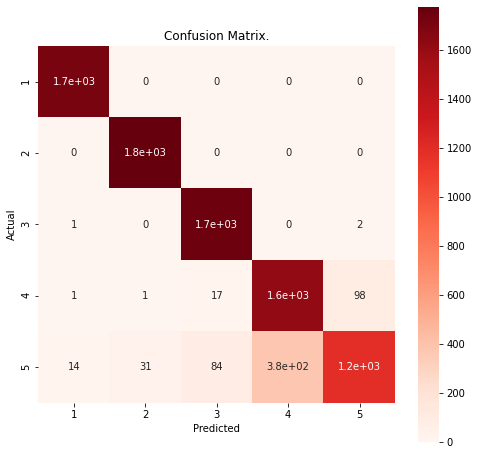

In [30]:
# plot the confusion matrix
def confusion_matrix_plot(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(cm, annot=True, cmap = 'Reds',square = True,xticklabels = [1,2,3,4,5],yticklabels=[1,2,3,4,5])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix.')

# calling the confusion_matrix_plot function
confusion_matrix_plot(y_test, y_pred)

In [31]:
print('Accuracy of the model {}'.format(accuracy_score(y_test, y_pred)))


Accuracy of the model 0.9277066758906952


In [ ]:
# report of the model
print('Report of the model {}'.format(classification_report(y_test, y_pred)))

In [32]:
# ploting the learning curver
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
       
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes,return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

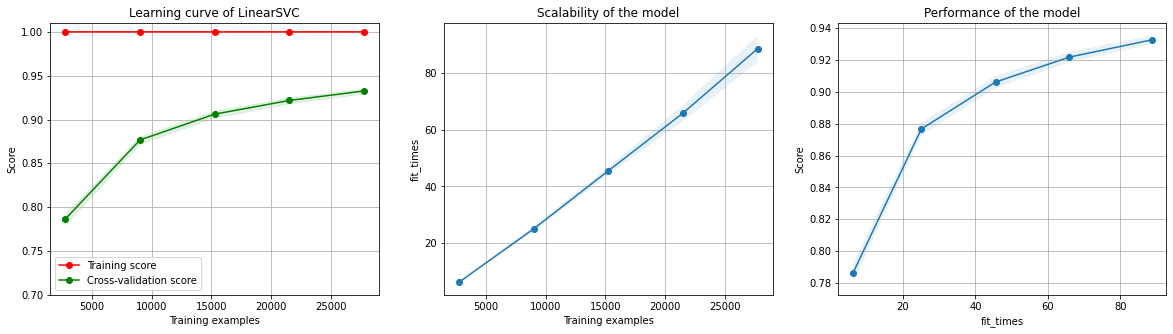

In [33]:
title = 'Learning curve of LinearSVC'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=100.0)
plot_learning_curve(estimator, title, x_res, y_res,  ylim=(0.7, 1.01),cv=cv, n_jobs=4)

In [35]:
# saving the model and feature extraction object
pickle.dump(model, open(os.path.join(path, 'model_nlp.pkl'), 'wb'))
pickle.dump(tfidf, open(os.path.join(path,'tfidf_nlp.pkl'), 'wb'))

# Task : 4
Perform an Exploratory Data Analysis for the Text Data (Reviews) and help the organisation to understand better about their customer feedbacks.

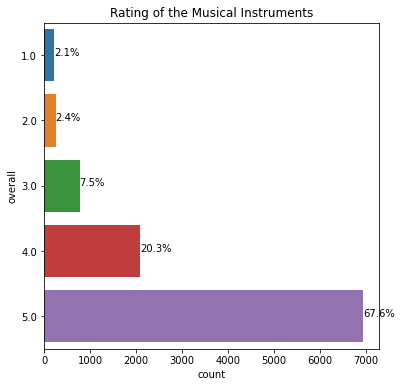

In [128]:
# rating of the insturiments
plt.figure(figsize=(6,6))
plt.title('Rating of the Musical Instruments')
ax = sns.countplot(y = 'overall', data = df_review)
total = len(df_review)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

In [261]:
all_words = df.review.values
negtive_words= df[df.overall <= 2.0]['review'].values
positive_words = df[df.overall >= 4.0]['review'].values

In [262]:
# conert string of list to word of list
def string_to_word(words):
  word = []
  for w in words:
    word.append(w.split())
  return word

In [267]:
# 10 most frequnt words
def most_frequent(word, title):
  word = string_to_word(word)
  word = list(chain.from_iterable(word))
  word = Counter(word)
  freq_words = word.most_common(10)

  y = [x[0] for x in freq_words]
  x = [x[1] for x in freq_words]
  plt.title(title)
  plt.bar(y, x)
  plt.show()

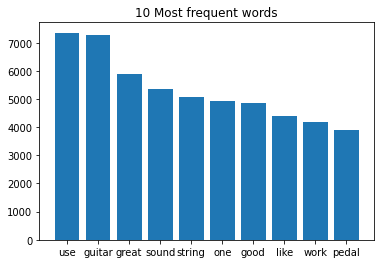

In [268]:
most_frequent(all_words, '10 Most frequent words')

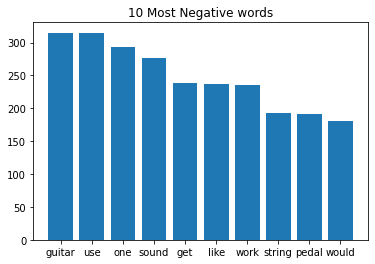

In [269]:
most_frequent(negtive_words, '10 Most Negative words')

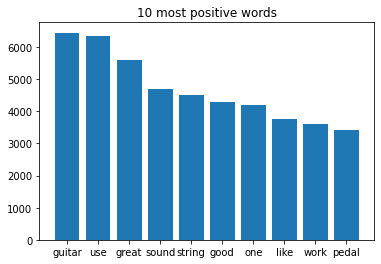

In [270]:
most_frequent(positive_words, '10 most positive words')

# Task : 5
Also create an anonymous function which takes text data as input and predicts it into either Positive, Negative or Neutral based on the model built above. It must be in a separate Python(.py) file, one just have to give the text input and run the script to get the predictions.


In [119]:
text = input('Enter the review ')

Enter the review I recently bought this product on Amazon and have been using it for a few weeks now. The product is top notch and I haven’t faced a single issue with it. Laptops with similar features will cost over 1 Lakh. This All-in-One was a steal at 70K. Just blindly go for it.


In [102]:
# function for text pre-processsed
def text_preprocessing(text):

  # removing the punctuation
  text = clean(text)
  
  # removing the stop words
  nltk.download('stopwords')
  text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
  
  # lemmitize
  nltk.download('wordnet')
  lemmitizer = WordNetLemmatizer()
  text = ' '.join([lemmitizer.lemmatize(word) for word in text.split()])

  # stemming 
  ps = PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])

  return text


In [48]:
# function for features extraction
def feature_extraction(text):
  # loading the features extraction object
  tfidf = pickle.load(open(os.path.join(path, 'tfidf_nlp.pkl'),'rb'))
  # transform the features
  return tfidf.transform(text)


In [49]:
# sentiment function
def sentiment(y):
  if y == 1.0 or y==2.0:
    return 'Negative'
  elif y == 3.0:
    return 'Netural'
  elif y == 4.0 or y == 5.0:
    return 'Positive'

In [111]:
# Sentiment predication function
def predict_sentiment(feature):
  # loading the model
  model = pickle.load(open(os.path.join(path, 'model_nlp.pkl'),'rb'))
  # predict the sentiment
  y = model.predict(feature)
  return sentiment(y)

In [120]:
text = text_preprocessing(text)
feature = feature_extraction([text])
predict_sentiment(feature)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[5.]


'Positive'